# Scikit-Optimize

In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline as Sklearn_Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
from skopt.plots import plot_convergence, plot_evaluations, plot_objective

Load Data

In [2]:
df = pd.read_csv("train.csv",sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Convert the target variable to integer

In [3]:
df['y'] = df['y'].map({'yes':1,'no':0})

Split full data into train and test data

In [4]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0) 

Get list of numerical features

In [5]:
numerical_feats = list(df_train.drop(columns='y').select_dtypes(include=np.number).columns)

Get list of categorical features

In [6]:
categorical_feats = list(df_train.drop(columns='y').select_dtypes(exclude=np.number).columns)

Initiate the preprocessors

In [7]:
# Initiate the Normalization Pre-processing for Numerical Features
numeric_preprocessor = StandardScaler()

# Initiate the One-Hot-Encoding Pre-processing for Categorical Features
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

Create the ColumnTransformer Class to delegate each preprocessor to the corresponding features

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocessor, numerical_feats),
        ("cat", categorical_preprocessor, categorical_feats),
    ]
)

Create a Pipeline of preprocessor and model

In [9]:
pipe = Sklearn_Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("model", RandomForestClassifier(random_state=0))]
)

Get all features from the train data

In [10]:
X_train_full = df_train.drop(columns=['y'])
y_train = df_train['y']

X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40689 entries, 17974 to 2732
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40689 non-null  int64 
 1   job        40689 non-null  object
 2   marital    40689 non-null  object
 3   education  40689 non-null  object
 4   default    40689 non-null  object
 5   balance    40689 non-null  int64 
 6   housing    40689 non-null  object
 7   loan       40689 non-null  object
 8   contact    40689 non-null  object
 9   day        40689 non-null  int64 
 10  month      40689 non-null  object
 11  duration   40689 non-null  int64 
 12  campaign   40689 non-null  int64 
 13  pdays      40689 non-null  int64 
 14  previous   40689 non-null  int64 
 15  poutcome   40689 non-null  object
dtypes: int64(7), object(9)
memory usage: 5.3+ MB


Get all features from the test data

In [11]:
X_test_full = df_test.drop(columns=['y'])
y_test = df_test['y']

X_test_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4522 entries, 14001 to 25978
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4522 non-null   int64 
 1   job        4522 non-null   object
 2   marital    4522 non-null   object
 3   education  4522 non-null   object
 4   default    4522 non-null   object
 5   balance    4522 non-null   int64 
 6   housing    4522 non-null   object
 7   loan       4522 non-null   object
 8   contact    4522 non-null   object
 9   day        4522 non-null   int64 
 10  month      4522 non-null   object
 11  duration   4522 non-null   int64 
 12  campaign   4522 non-null   int64 
 13  pdays      4522 non-null   int64 
 14  previous   4522 non-null   int64 
 15  poutcome   4522 non-null   object
dtypes: int64(7), object(9)
memory usage: 600.6+ KB


Calculate F1-Score on Test Data without Hyperparameter Tuning

In [12]:
# Fit the pipeline on train data 
pipe.fit(X_train_full,y_train)

# Evaluate on the test data 
y_pred = pipe.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.5164319248826291


Define the hyperparameter space

In [13]:
hyperparameter_space = {
"model__n_estimators": Integer(low=5, high=200), 
"model__criterion": Categorical(["gini", "entropy"]),
"model__class_weight": Categorical(["balanced","balanced_subsample"]),
} 

## BOGP

Perform Bayesian Optimization Gaussian Process

In [14]:
# Initiate the BOGP Class
clf = BayesSearchCV(pipe, hyperparameter_space,
                    n_iter=50,
                    optimizer_kwargs={"base_estimator":"GP",
                                      "n_initial_points":10,
                                      "initial_point_generator":"random",
                                      "acq_func":"EI",
                                      "acq_optimizer":"auto",
                                      "n_jobs":-1,
                                      "random_state":0,
                                      "acq_func_kwargs": {"xi":0.01}
                                     },
                    random_state = 0,
                    scoring = 'f1', cv=5, 
                    n_jobs=-1, refit = True,
                    verbose=2)

# Run the BOGP CV
clf.fit(X_train_full, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/louisowen6/miniconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/louisowen6/miniconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/louisowen6/miniconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/louisowen6/miniconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/louisowen6/miniconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          StandardScaler(),
                                                                          ['age',
                                                                           'balance',
                                                                           'day',
                                                                           'duration',
                                                                           'campaign',
                                                                           'pdays',
                                                                           'previous']),
                                                                         ('cat',
                                                                        

In [15]:
clf.best_params_,clf.best_score_

(OrderedDict([('model__class_weight', 'balanced'),
              ('model__criterion', 'entropy'),
              ('model__n_estimators', 23)]),
 0.4720977497697015)

In [16]:
clf.score(X_test_full,y_test)

0.49574726609963554

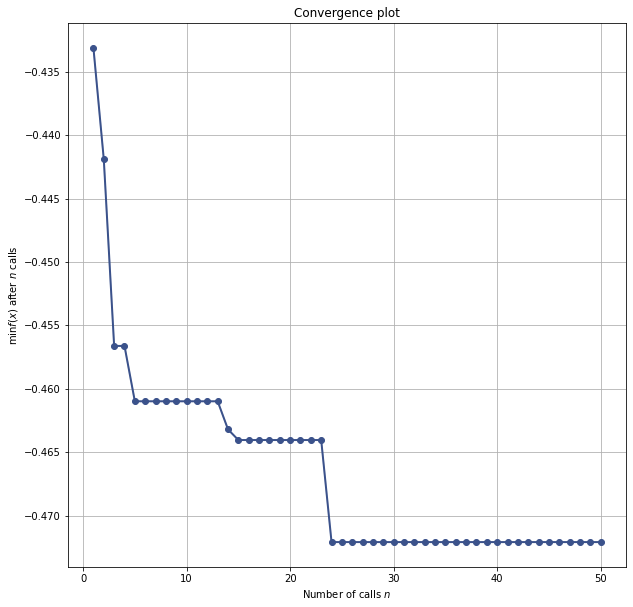

In [17]:
plt.figure(figsize=(10,10))
plot_convergence(clf.optimizer_results_)
plt.show()

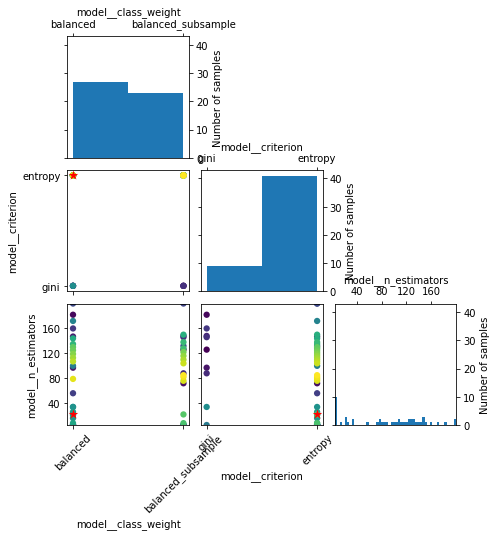

In [18]:
plot_evaluations(clf.optimizer_results_[-1], bins=50)
plt.show()

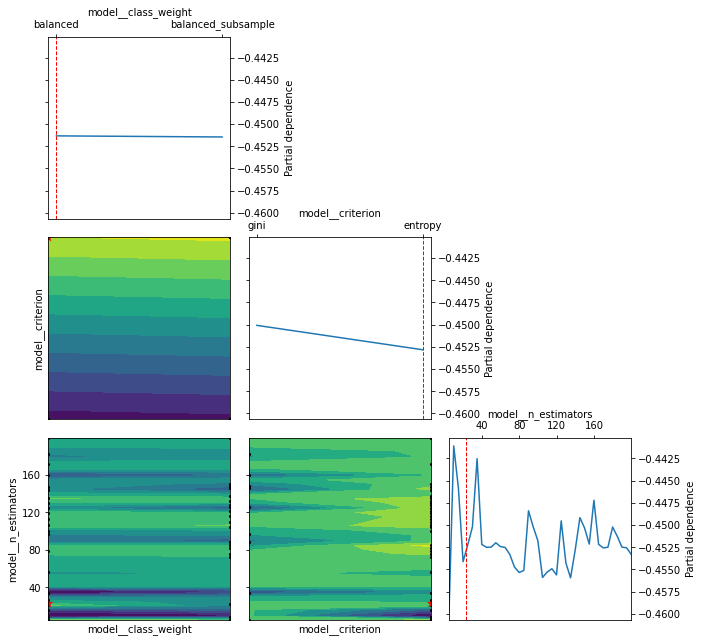

In [19]:
plot_objective(clf.optimizer_results_[-1], size=3)
plt.show()

# Optuna

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras import backend as K

import optuna

In [21]:
import warnings
warnings.filterwarnings("ignore")

# Function Definition

Create model architecture function

In [22]:
def create_model(trial: optuna.trial.Trial, input_size: int): 
    model = Sequential()
    model.add(Dense(input_size,input_shape=(input_size,),activation='relu')) 

    num_layers = trial.suggest_int('num_layers',low=0,high=3)  
    for layer_i in range(num_layers):  
        n_units = trial.suggest_int(f'n_units_layer_{layer_i}',low=10,high=50,step=5)  
        dropout_rate = trial.suggest_float(f'dropout_rate_layer_{layer_i}',low=0,high=0.5)  
        actv_func = trial.suggest_categorical(f'actv_func_layer_{layer_i}',['relu','tanh','elu'])  

        model.add(Dropout(dropout_rate))  
        model.add(Dense(n_units,activation=actv_func)) 

    model.add(Dense(1,activation='sigmoid')) 
    return model 

Create optimizers function

In [23]:
def create_optimizer(trial: optuna.trial.Trial): 
	opt_kwargs = {} 
	opt_selected = trial.suggest_categorical('optimizer', ['Adam','SGD']) 
	if opt_selected == 'SGD': 
		opt_kwargs['lr'] = trial.suggest_float('sgd_lr',1e-5,1e-1,log=True) 
		opt_kwargs['momentum'] = trial.suggest_float('sgd_momentum',1e-5,1e-1,log=True) 
	else: #’Adam’ 
		opt_kwargs['lr'] = trial.suggest_float('adam_lr',1e-5,1e-1,log=True) 

	optimizer = getattr(tf.optimizers,opt_selected)(**opt_kwargs) 
	return optimizer

Create custom metric

In [24]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Create the preprocessing function

In [25]:
def preprocessing(X: pd.DataFrame, 
                  numeric_preprocessor, categorical_preprocessor,
                  is_train = True
                 ):
    if is_train:
        X[numerical_feats] = numeric_preprocessor.fit_transform(X[numerical_feats])
        X_cat = categorical_preprocessor.fit_transform(X[categorical_feats]).toarray()
        X_cat = pd.DataFrame(X_cat,columns=categorical_preprocessor.get_feature_names_out())
        X = X.drop(columns=categorical_feats).reset_index(drop=True)
        X = pd.concat([X,X_cat],axis=1)
    else:
        X[numerical_feats] = numeric_preprocessor.transform(X[numerical_feats])
        X_cat = categorical_preprocessor.transform(X[categorical_feats]).toarray()
        X_cat = pd.DataFrame(X_cat,columns=categorical_preprocessor.get_feature_names_out())
        X = X.drop(columns=categorical_feats).reset_index(drop=True)
        X = pd.concat([X,X_cat],axis=1)
    
    return X, numeric_preprocessor, categorical_preprocessor

Create the train function

In [26]:
def train(trial, df_train: pd.DataFrame, df_val: pd.DataFrame = None, use_pruner: bool = False):
    X_train,y_train = df_train.drop(columns=['y']), df_train['y']
    
    if df_val is not None:
        X_val,y_val = df_val.drop(columns=['y']), df_val['y'] 

    #Preprocessing
    numeric_preprocessor = StandardScaler()
    categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
    
    X_train,numeric_preprocessor,categorical_preprocessor = preprocessing(X_train,
                                                                          numeric_preprocessor,
                                                                          categorical_preprocessor,
                                                                          is_train=True)
    if df_val is not None:
        X_val,_,_ = preprocessing(X_val,
                                  numeric_preprocessor,categorical_preprocessor,
                                  is_train=False)

    #Build model & optimizer
    model = create_model(trial,X_train.shape[1])
    optimizer = create_optimizer(trial)
    
    callbacks = []
    if use_pruner:
        callbacks.append(optuna.integration.TFKerasPruningCallback(trial,'val_f1_m'))

    model.compile(loss='binary_crossentropy',optimizer=optimizer,
                  metrics=[f1_m],
                 )
    history = model.fit(X_train,y_train,
                        epochs=trial.suggest_int('epoch',15,50),
                        batch_size=64,
                        validation_data=(X_val,y_val) if df_val is not None else None,
                        callbacks=callbacks,
                        verbose=False
                       )
    if df_val is not None:
        return np.mean(history.history['val_f1_m'])
    else:
        return model

Create the objective function

In [27]:
def objective(trial: optuna.trial.Trial, df_train: pd.DataFrame, use_pruner: bool = False): 
    #Split into Train and Validation data
    df_train_hp, df_val = train_test_split(df_train, test_size=0.1, random_state=0)
    
    # Train and Validate Model
    val_f1_score = train(trial, df_train_hp, df_val, use_pruner)
        
    return val_f1_score

Create the final train and evaluation function to test the best set of hyperparmeters

In [28]:
def train_and_evaluate_final(df_train: pd.DataFrame, df_test: pd.DataFrame, **kwargs):
    X_train,y_train = df_train.drop(columns=['y']), df_train['y']
    X_test,y_test = df_test.drop(columns=['y']), df_test['y'] 
    
    # Preprocessing
    numeric_preprocessor = StandardScaler()
    categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
    X_train,numeric_preprocessor,categorical_preprocessor = preprocessing(X_train,
                                                                          numeric_preprocessor,
                                                                          categorical_preprocessor,
                                                                          is_train=True)
    X_test,_,_ = preprocessing(X_test,numeric_preprocessor,categorical_preprocessor,
                              is_train=False)

    #Build model
    input_size = X_train.shape[1]
    model = Sequential()
    model.add(Dense(input_size,input_shape=(input_size,),activation='relu')) 

    num_layers = kwargs.get('num_layers',0)  
    for layer_i in range(num_layers):  
        n_units = kwargs.get(f'n_units_layer_{layer_i}',0)  
        dropout_rate = kwargs.get(f'dropout_rate_layer_{layer_i}',0)  
        actv_func = kwargs.get(f'actv_func_layer_{layer_i}','relu')  

        model.add(Dropout(dropout_rate))  
        model.add(Dense(n_units,activation=actv_func)) 

    model.add(Dense(1,activation='sigmoid'))
    
    #Build Optimizer
    opt_kwargs = {} 
    opt_selected = kwargs.get('optimizer', 'Adam')
    if opt_selected == 'SGD': 
        opt_kwargs['lr'] = kwargs.get('sgd_lr',1e-5) 
        opt_kwargs['momentum'] = kwargs.get('sgd_momentum',1e-5) 
    else: #’Adam’ 
        opt_kwargs['lr'] = kwargs.get('adam_lr',1e-5) 

    optimizer = getattr(tf.optimizers,opt_selected)(**opt_kwargs) 
    
    #Training process
    model.compile(loss='binary_crossentropy',optimizer=optimizer,
                  metrics=[f1_m],
                 )
    print(model.summary())
    history = model.fit(X_train,y_train,
                        epochs=kwargs.get('epoch',15),
                        batch_size=64,
                        validation_data=None,
                        verbose=True
                       )
    
    # Evaluation Process
    y_test_pred_probas = model.predict(X_test)
    y_test_pred = [1 if x[0]>0.5 else 0 for x in y_test_pred_probas]
    
    print("="*100)
    print("F1-Score on Test Data: ",f1_score(y_test, y_test_pred))

Load Data

In [29]:
df = pd.read_csv("train.csv",sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Convert the target variable to integer

In [30]:
df['y'] = df['y'].map({'yes':1,'no':0})

Split full data into train and test data

In [31]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0) 

Get list of numerical features

In [32]:
numerical_feats = list(df_train.drop(columns='y').select_dtypes(include=np.number).columns)

Get list of categorical features

In [33]:
categorical_feats = list(df_train.drop(columns='y').select_dtypes(exclude=np.number).columns)

Perform Hyperparameter Tuning with TPE

In [34]:
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=0),
                           )
study.optimize(lambda trial: objective(trial, df_train),
               n_trials=50, n_jobs=-1,
              )

[I 2022-07-05 11:06:24,872] A new study created in memory with name: no-name-3738dda6-db01-460b-8768-a3692b55c77f


[I 2022-07-05 11:09:55,461] Trial 0 finished with value: 0.5264557580153147 and parameters: {'num_layers': 0, 'optimizer': 'Adam', 'adam_lr': 0.0021863232381745257, 'epoch': 15}. Best is trial 0 with value: 0.5264557580153147.
[I 2022-07-05 11:10:51,741] Trial 12 finished with value: 0.10631164256483316 and parameters: {'num_layers': 2, 'n_units_layer_0': 35, 'dropout_rate_layer_0': 0.10438362164354531, 'actv_func_layer_0': 'relu', 'n_units_layer_1': 25, 'dropout_rate_layer_1': 0.4861550114080753, 'actv_func_layer_1': 'elu', 'optimizer': 'Adam', 'adam_lr': 0.0409268238683911, 'epoch': 16}. Best is trial 0 with value: 0.5264557580153147.
[I 2022-07-05 11:11:30,335] Trial 6 finished with value: 0.544816465754258 and parameters: {'num_layers': 0, 'optimizer': 'Adam', 'adam_lr': 0.021790046399485147, 'epoch': 19}. Best is trial 6 with value: 0.544816465754258.
[I 2022-07-05 11:12:53,520] Trial 10 finished with value: 0.3517195666208863 and parameters: {'num_layers': 3, 'n_units_layer_0': 1

In [35]:
print("Best Trial:")
best_trial = study.best_trial

print("    Value: ", best_trial.value)

print("    Hyperparameters: ")
for key, value in best_trial.params.items():
    print(f"        {key}: {value}")

Best Trial:
    Value:  0.5656033590916665
    Hyperparameters: 
        num_layers: 3
        n_units_layer_0: 45
        dropout_rate_layer_0: 0.0008072514440390921
        actv_func_layer_0: elu
        n_units_layer_1: 50
        dropout_rate_layer_1: 0.01641528123410832
        actv_func_layer_1: relu
        n_units_layer_2: 10
        dropout_rate_layer_2: 0.48963825059790184
        actv_func_layer_2: elu
        optimizer: Adam
        adam_lr: 0.0034601264996507513
        epoch: 31


In [36]:
best_trial.params

{'num_layers': 3,
 'n_units_layer_0': 45,
 'dropout_rate_layer_0': 0.0008072514440390921,
 'actv_func_layer_0': 'elu',
 'n_units_layer_1': 50,
 'dropout_rate_layer_1': 0.01641528123410832,
 'actv_func_layer_1': 'relu',
 'n_units_layer_2': 10,
 'dropout_rate_layer_2': 0.48963825059790184,
 'actv_func_layer_2': 'elu',
 'optimizer': 'Adam',
 'adam_lr': 0.0034601264996507513,
 'epoch': 31}

In [37]:
train_and_evaluate_final(df_train, df_test, **best_trial.params)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 51)                2652      
_________________________________________________________________
dropout (Dropout)            (None, 51)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 45)                2340      
_________________________________________________________________
dropout_1 (Dropout)          (None, 45)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2300      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5

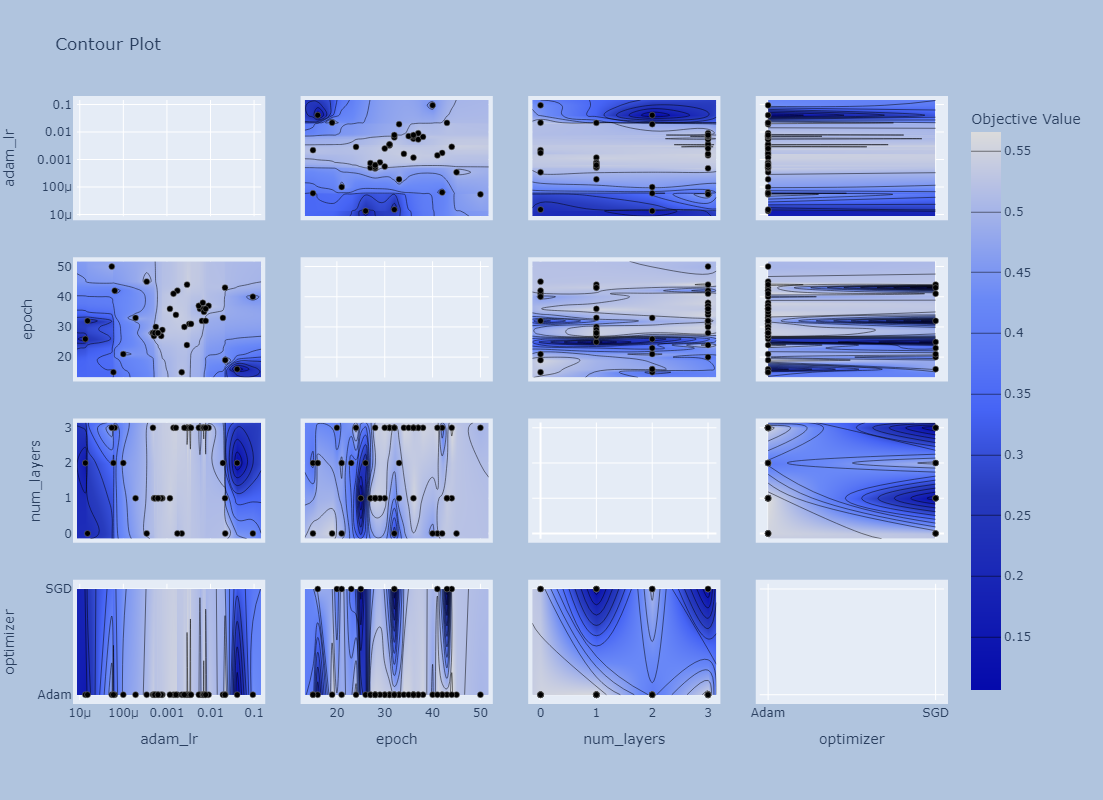

In [38]:
fig = optuna.visualization.plot_contour(study, params=['num_layers',
                                                'optimizer',
                                                'adam_lr',
                                                'epoch'
                                               ])
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)

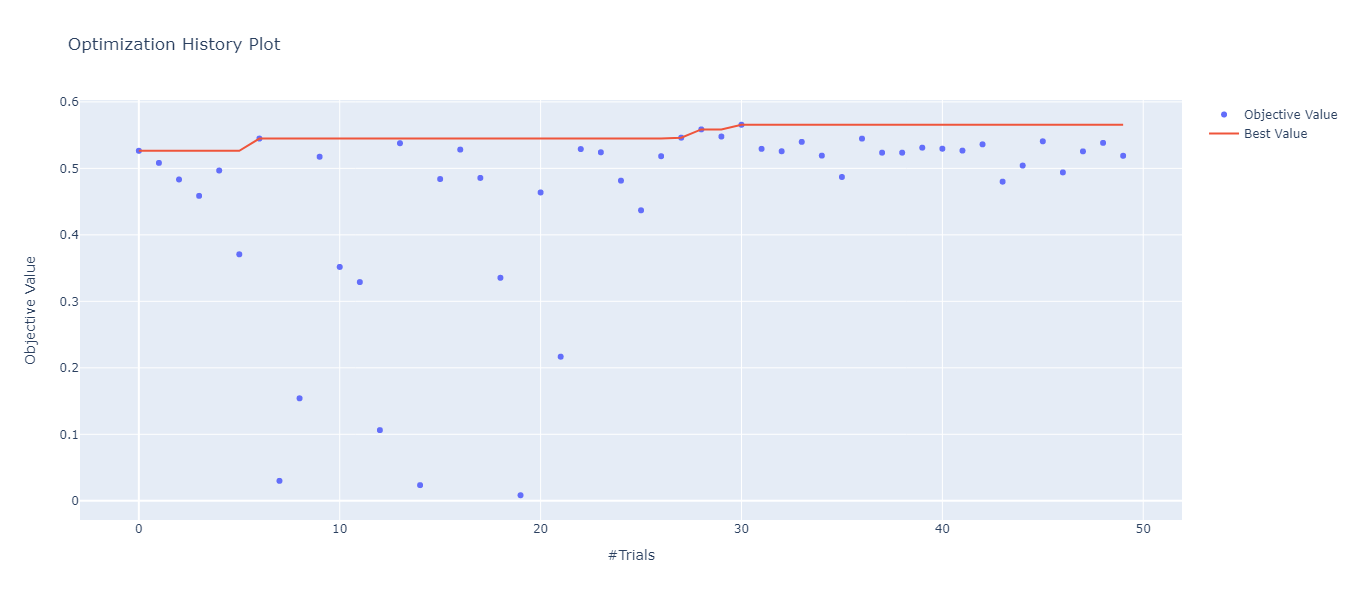

In [39]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(
    autosize=False,
    width=1100,
    height=600,
)
fig.update_xaxes(automargin=True)

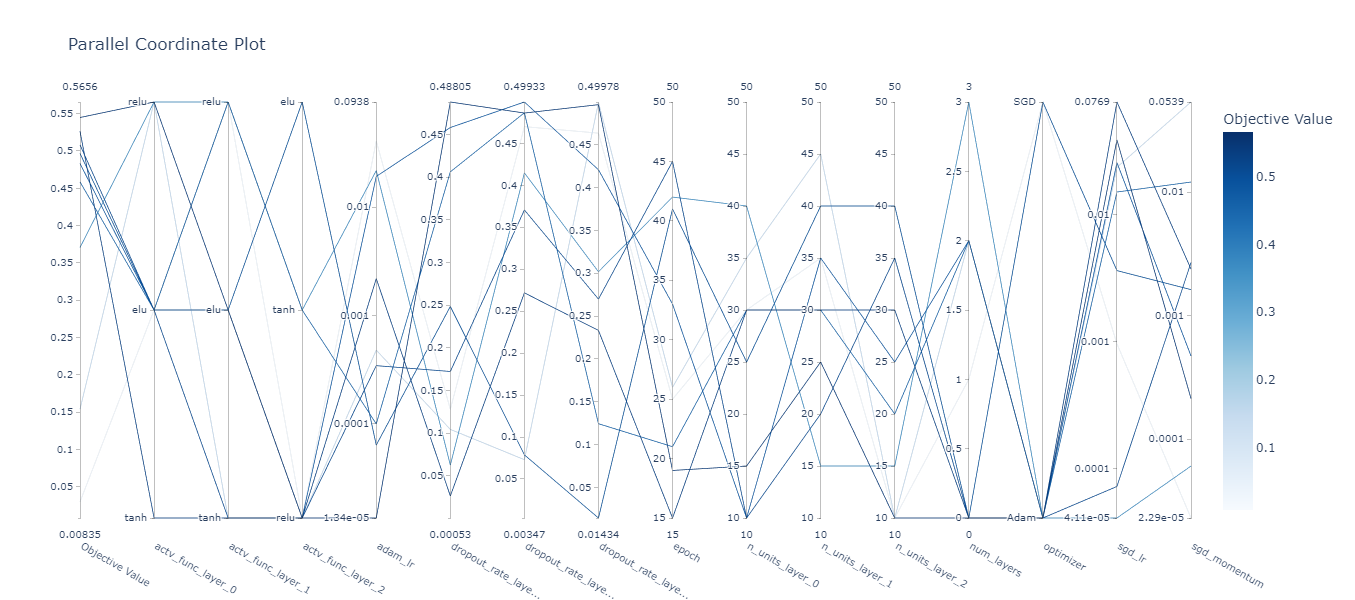

In [40]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(
    autosize=False,
    width=1100,
    height=600,
)
fig.update_xaxes(automargin=True)

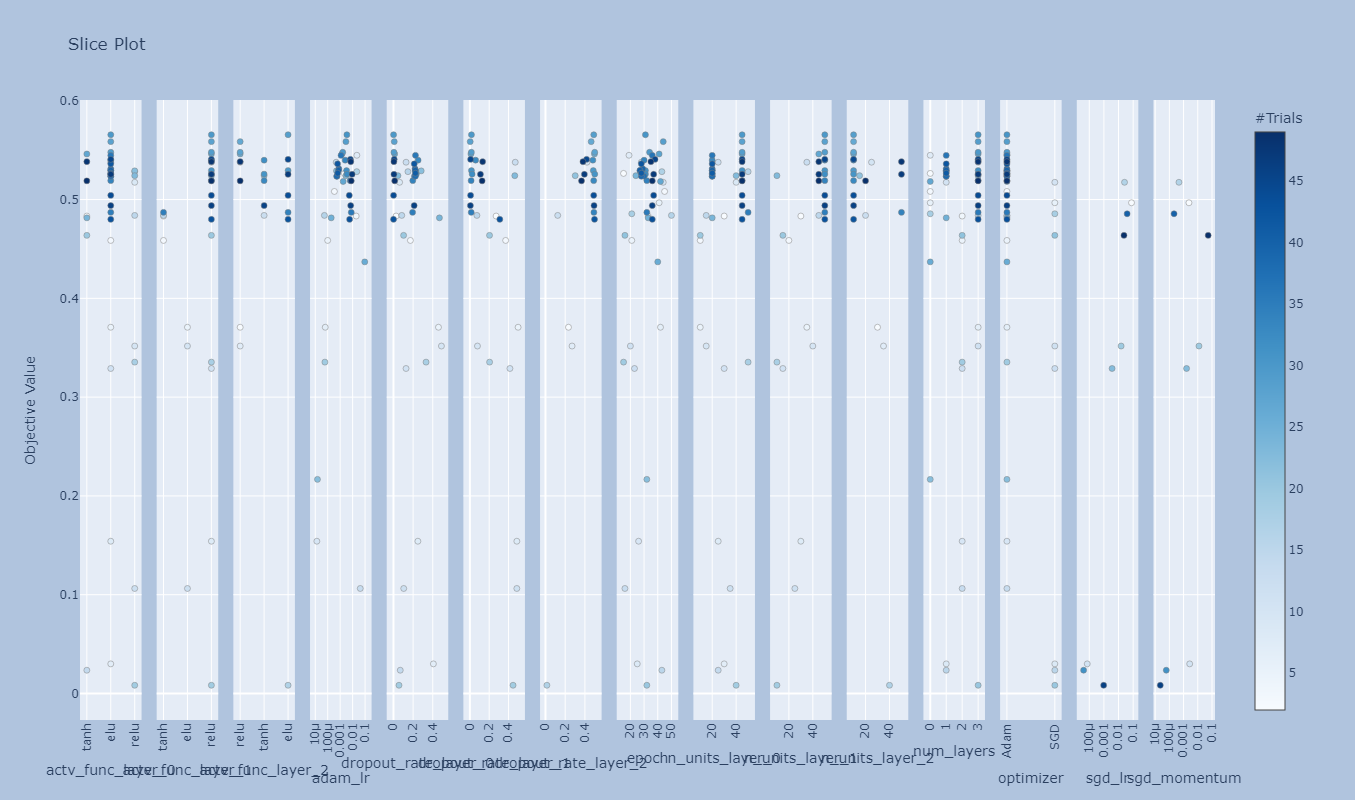

In [41]:
fig = optuna.visualization.plot_slice(study)
fig.update_layout(
    autosize=False,
    width=2200,
    height=800,
    paper_bgcolor="LightSteelBlue",
)
fig.update_xaxes(automargin=True,tickangle=-90)

# NNI

In [42]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier

from nni.experiment import Experiment

In [43]:
df = pd.read_csv("train.csv",sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Convert the target variable to integer

In [44]:
df['y'] = df['y'].map({'yes':1,'no':0})

Split full data into train and test data

In [45]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0) 

Get list of numerical features

In [46]:
numerical_feats = list(df_train.drop(columns='y').select_dtypes(include=np.number).columns)

Get list of categorical features

In [47]:
categorical_feats = list(df_train.drop(columns='y').select_dtypes(exclude=np.number).columns)

Initiate the preprocessors

In [48]:
# Initiate the Normalization Pre-processing for Numerical Features
numeric_preprocessor = StandardScaler()

# Initiate the One-Hot-Encoding Pre-processing for Categorical Features
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

Create the ColumnTransformer Class to delegate each preprocessor to the corresponding features

In [49]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocessor, numerical_feats),
        ("cat", categorical_preprocessor, categorical_feats),
    ]
)

Create a Pipeline of preprocessor and model

In [50]:
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("model", RandomForestClassifier(random_state=0))]
)

Get all features from the train data

In [51]:
X_train_full = df_train.drop(columns=['y'])
y_train = df_train['y']

X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40689 entries, 17974 to 2732
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40689 non-null  int64 
 1   job        40689 non-null  object
 2   marital    40689 non-null  object
 3   education  40689 non-null  object
 4   default    40689 non-null  object
 5   balance    40689 non-null  int64 
 6   housing    40689 non-null  object
 7   loan       40689 non-null  object
 8   contact    40689 non-null  object
 9   day        40689 non-null  int64 
 10  month      40689 non-null  object
 11  duration   40689 non-null  int64 
 12  campaign   40689 non-null  int64 
 13  pdays      40689 non-null  int64 
 14  previous   40689 non-null  int64 
 15  poutcome   40689 non-null  object
dtypes: int64(7), object(9)
memory usage: 5.3+ MB


Get all features from the test data

In [52]:
X_test_full = df_test.drop(columns=['y'])
y_test = df_test['y']

X_test_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4522 entries, 14001 to 25978
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4522 non-null   int64 
 1   job        4522 non-null   object
 2   marital    4522 non-null   object
 3   education  4522 non-null   object
 4   default    4522 non-null   object
 5   balance    4522 non-null   int64 
 6   housing    4522 non-null   object
 7   loan       4522 non-null   object
 8   contact    4522 non-null   object
 9   day        4522 non-null   int64 
 10  month      4522 non-null   object
 11  duration   4522 non-null   int64 
 12  campaign   4522 non-null   int64 
 13  pdays      4522 non-null   int64 
 14  previous   4522 non-null   int64 
 15  poutcome   4522 non-null   object
dtypes: int64(7), object(9)
memory usage: 600.6+ KB


Define hyperparameter space

In [53]:
hyperparameter_space = { 
    'model__n_estimators': {'_type': 'randint', '_value': [5, 200]}, 
    'model__criterion': {'_type': 'choice', '_value': ['gini', 'entropy']}, 
    'model__class_weight': {'_type': 'choice', '_value': ["balanced","balanced_subsample"]}, 
    'model__min_samples_split': {'_type': 'uniform', '_value': [0, 0.1]}, 
}  

## Random Search

In [54]:
experiment = Experiment('local')

experiment.config.experiment_name = 'nni_sklearn_random_search'
experiment.config.tuner.name = 'Random'
experiment.config.tuner.class_args['seed'] = 0

# Boilerplate code
experiment.config.trial_command = "python '/mnt/c/Users/Louis\ Owen/Desktop/Packt/Hyperparameter-Tuning-with-Python/nni/model.py'"  #please change this to your own local path
experiment.config.trial_code_directory = '.'
experiment.config.search_space = hyperparameter_space
experiment.config.max_trial_number = 100
experiment.config.trial_concurrency = 10
experiment.config.max_experiment_duration = '1h'

In [55]:
experiment.run(8080, wait_completion = True, debug = False)

[2022-07-05 12:16:34] Creating experiment, Experiment ID: 6wz3lm0d
[2022-07-05 12:16:34] Starting web server...
[2022-07-05 12:16:35] Setting up...
[2022-07-05 12:16:35] Web portal URLs: http://127.0.0.1:8080 http://172.30.237.80:8080


True

In [56]:
best_trial = sorted(experiment.export_data(),key = lambda x: x.value, reverse = True)[0]
print(best_trial.value, best_trial.parameter)

0.599735399016607 {'model__n_estimators': 194, 'model__criterion': 'entropy', 'model__class_weight': 'balanced_subsample', 'model__min_samples_split': 0.0014706304965369289}


In [57]:
tuned_pipe = clone(pipe).set_params(**best_trial.parameter)

# Fit the pipeline on train data 
tuned_pipe.fit(X_train_full,y_train)

# Evaluate on the test data 
y_pred = tuned_pipe.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.5973333333333333


In [58]:
experiment.stop()

[2022-07-05 12:21:12] Stopping experiment, please wait...
[2022-07-05 12:21:15] Experiment stopped


# MLFlow

In [59]:
import os
from random import random, randint
import mlflow

In [60]:
mlflow.create_experiment("example1")
mlflow.set_experiment("example1")

<Experiment: artifact_location='file:///mnt/c/Users/Louis%20Owen/Desktop/Packt/Hyperparameter-Tuning-with-Python/mlruns/6', experiment_id='6', lifecycle_stage='active', name='example1', tags={}>

In [61]:
with mlflow.start_run(run_name='PARENT_RUN') as parent_run:
    mlflow.set_tag("release.version", "2.2.0")

    # Log a parameter (key-value pair)
    mlflow.log_param("param1", randint(0, 100))

    # Log a metric; metrics can be updated throughout the run
    mlflow.log_metric(key = "foo", value = random(), step = 1)
    mlflow.log_metric(key = "foo", value = random() + 1, step = 2)
    mlflow.log_metric(key = "foo", value = random() + 2, step = 3)

    # Log an artifact (output file)
    if not os.path.exists("outputs"):
        os.makedirs("outputs")
    with open("outputs/test.txt", "w") as f:
        f.write("hello world!")
    mlflow.log_artifacts("outputs")
    
    with mlflow.start_run(run_name='CHILD_RUN', nested=True) as child_run:
        mlflow.log_param("child", "yes")